In [ ]:
# download ktrain
!pip install ktrain

#import ktrain and the ktrain.text modules
import ktrain
from ktrain import text

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# read the dataset
import pandas as pd
from sklearn.model_selection import train_test_split

train_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/test.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/train.csv")
valid_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/val.csv")

list_dataset = [train_dataset, test_dataset, valid_dataset]

dataset = pd.concat(list_dataset)

Xfeatures = dataset['Text']
ylabels = dataset['Emotion']

#  Split Data
x_train, x_test, y_train, y_test = train_test_split(Xfeatures, ylabels, test_size=0.1, random_state=41)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=41)

# convert pandas series to list
x_train = x_train.tolist()
x_test = x_test.tolist()
x_val = x_val.tolist()

y_train = y_train.tolist()
y_test = y_test.tolist()
y_val = y_val.tolist()

In [ ]:
# Create a Transformer instance
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 256 # maximum sequence length. The longest sequence in our training set is 47.
class_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
t = text.Transformer(MODEL_NAME, MAX_LEN, class_names=class_names)

In [ ]:
# Preprocess the Datasets
trn = t.preprocess_train(x_train, y_train)
tst = t.preprocess_test(x_test, y_test)
val = t.preprocess_train(x_val, y_val)


preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 41
	99percentile : 52


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 40
	99percentile : 51


preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 40
	99percentile : 53


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False


In [ ]:
# Create a Model and Wrap in Learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=25)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
612/612 [==============================] - 789s 1s/step - loss: 1.3733 - accuracy: 0.4552
Epoch 2/2
612/612 [==============================] - 394s 638ms/step - loss: 12.0519 - accuracy: 0.2703


done.
Visually inspect loss plot and select learning rate associated with falling loss


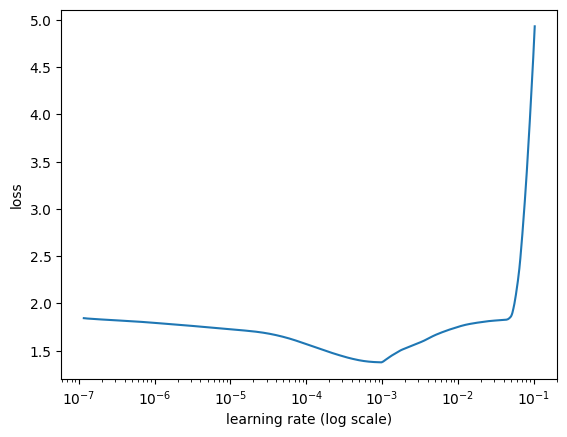

In [ ]:
# Estimate a Good Learning Rate
learner.lr_find(show_plot=True, max_epochs=2)

Three possible suggestions for LR from plot:
	Longest valley (red): 9.85E-06
	Min numerical gradient (purple): 9.85E-05
	Min loss divided by 10 (omitted from plot): 9.85E-05


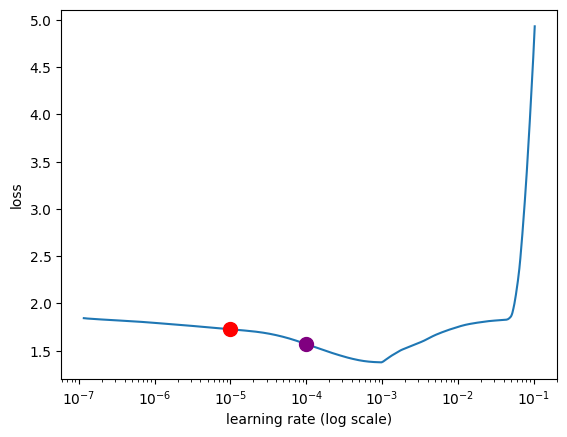

In [ ]:
# Plos the loss vs. learning rate to help identify The maximal learning rate associated with a falling loss.
learner.lr_plot(suggest=True)

Given the `Longest valley (red): : 9.85E-06` and `Min numerical gradient (purple): 9.85E-05` we can calculate the Median to find the Learning Rate, which is ~**5.42e-5**. For our training we will use the number **5e-5**.

In [ ]:
# Train Model
learner.fit_onecycle(5e-5, 6)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/6
612/612 [==============================] - 846s 1s/step - loss: 0.6273 - accuracy: 0.7814 - val_loss: 0.2074 - val_accuracy: 0.9248
Epoch 2/6
612/612 [==============================] - 816s 1s/step - loss: 0.1642 - accuracy: 0.9352 - val_loss: 0.1796 - val_accuracy: 0.9285
Epoch 3/6
612/612 [==============================] - 848s 1s/step - loss: 0.1187 - accuracy: 0.9482 - val_loss: 0.1668 - val_accuracy: 0.9322
Epoch 4/6
612/612 [==============================] - 817s 1s/step - loss: 0.1160 - accuracy: 0.9476 - val_loss: 0.1471 - val_accuracy: 0.9352
Epoch 5/6
612/612 [==============================] - 848s 1s/step - loss: 0.0711 - accuracy: 0.9665 - val_loss: 0.1467 - val_accuracy: 0.9274
Epoch 6/6
612/612 [==============================] - 816s 1s/step - loss: 0.0462 - accuracy: 0.9788 - val_loss: 0.1672 - val_accuracy: 0.9348


In [ ]:
# Evaluate/Inspect Model
learner.validate(class_names=class_names)

85/85 [==============================] - 55s 609ms/step
              precision    recall  f1-score   support

       anger       0.94      0.95      0.95       379
        fear       0.90      0.90      0.90       322
         joy       0.96      0.95      0.95       929
        love       0.82      0.86      0.84       219
     sadness       0.97      0.98      0.97       765
    surprise       0.74      0.70      0.72        86

    accuracy                           0.93      2700
   macro avg       0.89      0.89      0.89      2700
weighted avg       0.93      0.93      0.93      2700



array([[359,   7,   3,   1,   9,   0],
       [ 10, 290,   0,   0,  11,  11],
       [  0,   0, 878,  39,   3,   9],
       [  1,   0,  29, 189,   0,   0],
       [ 10,   2,   3,   1, 748,   1],
       [  0,  22,   3,   0,   1,  60]])

In [ ]:
# the one we got most wrong
learner.view_top_losses(n=1, preproc=t)

85/85 [==============================] - 51s 601ms/step
----------
id:2686 | loss:8.26 | true:fear | pred:sadness)



In [ ]:
# Calculate the success rate of test dataset using the accuracy_score
predictor = ktrain.get_predictor(learner.model, preproc=t)
test_y_predictions = predictor.predict(x_test)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, test_y_predictions)
print(score)

0.926


In [ ]:
# Make Predictions on New Data
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.predict("I can't imagine how hard it must be for you.")

'sadness'

# Save Model

In [ ]:
# save Predictor (i.e., model and Preprocessor instance) after partially training
predictor.save("/content/saved_model")